# Final project Vincent Honar  & Jonatan Frykmer
### _A comparison of HOG SVM, and CNN in character recognition for capitalised letters in the English Alphabet_

Research Question:
* How well does a convolutional neural network fare compared to a support vector machine with HOG features at recognising characters?
    * H0_1: CNN will have a statistically significant higher performance measure than SVM in accuracy and f1-score
    * H0_2: CNN will have a statistically significantly higher training time than SVM.
* Are these models usable in a real world scenario?

In [58]:
import cv2
import random
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,r2_score,classification_report

from sklearn.utils import shuffle
from sklearn import metrics, svm
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.api._v2.keras as keras
from keras.api._v2.keras import datasets, layers, models

In [59]:
df = pd.read_csv('A_Z Handwritten Data.csv')
df

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploration
### Goals
* Understand how the data is structured
* Look at some samples to see if the data is sound on a shallow level
* Identify potential problem areas to handle during preprocessing and model creation
* Examine sample distribution

Describe() can give a cursory understanding of how the data is structured

In [60]:
df.describe()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
count,372450.000000,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,372450.0,...,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000,372450.000000
mean,13.523490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001616,0.001592,0.001117,0.000929,0.000685,0.000596,0.000618,0.000690,0.000239,0.000011
std,6.740824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490788,0.517297,0.421332,0.419180,0.385566,0.319820,0.208942,0.335227,0.134852,0.006554
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,252.000000,226.000000,229.000000,228.000000,235.000000,194.000000,103.000000,198.000000,82.000000,4.000000


Two important properties can be noted from the describe():
* Column 0 contains the label of each letter. It could be assumed that the number coresponds to the letter's position in the alphabet.

* All the other columns are pixels, the majority of pixel values are zero. Since no letter can reasonably occupy the entirety of a 28x28 picture, a white values are the drawn parts of each image

### Visualisation of the data

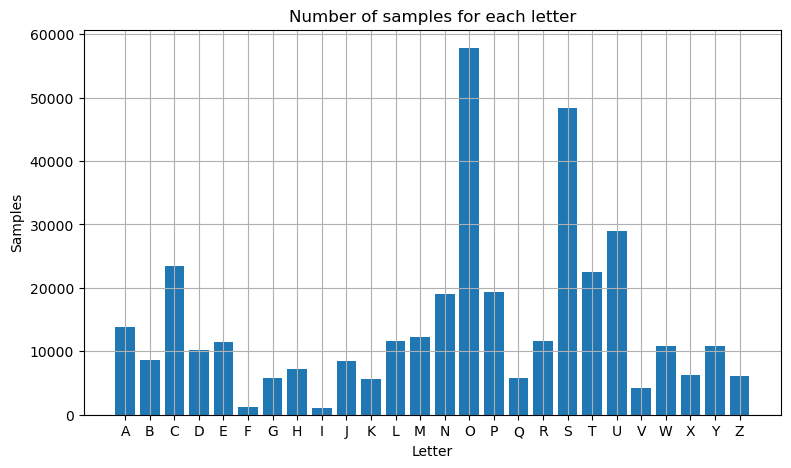

In [61]:
start = 65
ticks= []
for i in range(start,start+26):
    ticks.append(chr(i)) #generates our ticks for the plot
def plot_dist(df,title):
    y_int = np.int0(df) #Gives us a list of all rows for all classes
    count = np.zeros(26, dtype='int') #a vector of size 26 with all 0 values
    for i in y_int:
        count[i] +=1 #every time i = 3 for example, the coresponding slots value is increased by 1 to count the occurence of each letter 
        
    fig, ax = plt.subplots( figsize=(9,5))

    ax.bar(ticks, count)

    ax.set_title(title)
    plt.xlabel("Letter")
    plt.ylabel("Samples")

    plt.grid()
    plt.show()
    return count

count = plot_dist(df['0'],"Number of samples for each letter")

A great imbalance exists in the data set

In [62]:
print(f"I count: {count[ord('I')-ord('A')]} \nF count: {count[ord('F')-ord('A')]} \nO count: {count[ord('O')-ord('A')]}")

I count: 1120 
F count: 1163 
O count: 57825


There is a 1:57 ratio between the most populous letter in the data set contra the least popular.

Let's look at a random group of samples

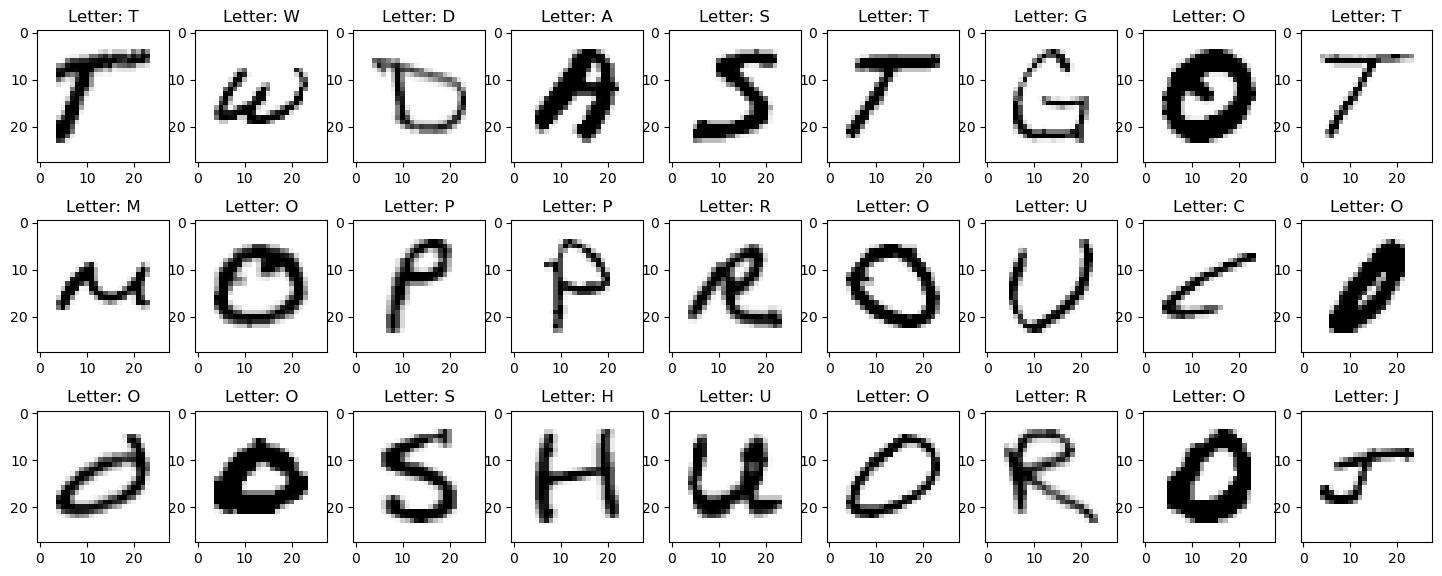

In [63]:
def display_letter(df,letter,dims):
    letters = df.loc[df['0'] == ord(letter)-ord('A')].drop('0', axis = 1)
    x,y = dims[0],dims[1]
    fig, ax = plt.subplots(x,y, figsize = (18,6))
    axes = ax.flatten()
    indices = []
    index=0
    for i in range(x*y): # For each generated plot pick out a new image to display until either you have no images left to choose from or the plot is full
        while index in indices and len(indices) < len(letters):
            index = random.randint(1,1000)%len(letters)
        indices.append(index)
        pic  = np.reshape(letters.iloc[index].values, (28,28))
        axes[i].imshow(pic, cmap="binary")
    plt.show()
    
def display_rand_letters(df):
    shuff = shuffle(df)
    x,y = 3,9
    fig, ax = plt.subplots(x,y, figsize = (18,7))
    axes = ax.flatten()

    for i,ax in enumerate(axes):
        
        im = shuff.iloc[i]
        letter = chr(im[0]+ord('A'))
        ax.set_title(f"Letter: {letter}")
        im = np.reshape(im[1:].values, (28,28))
        axes[i].imshow(im, cmap="Greys")

        #print(im)
    plt.show()
display_rand_letters(df)

#### Short Analysis:

* The data is widely varied for example:
    * both small and large letters seem to be mixed in for some letters (particularly the letter U) 
    * cursive L:s exist as-well as non cursive variants
    * Brushsize varies
    * Certain letters are rotated
* Every letter is centered in the middle
* This method of looking at letters results in the big classes being over represented
***


Let's compare some letters to get a better grasp of what potential problems might occur

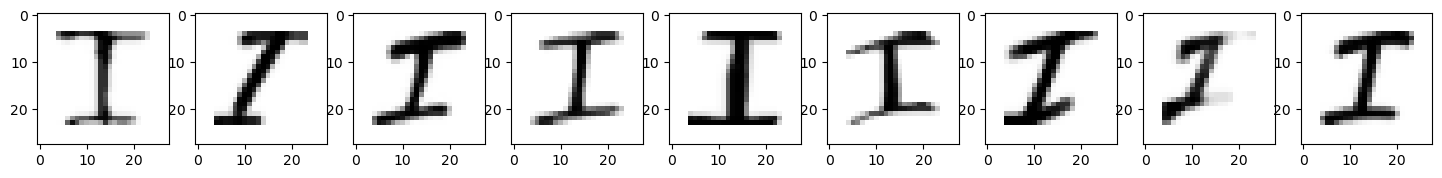

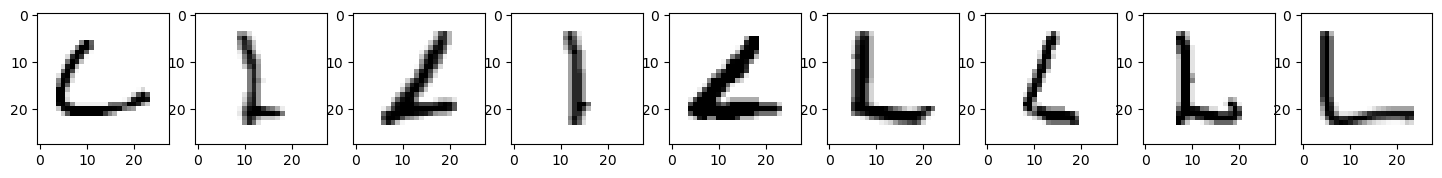

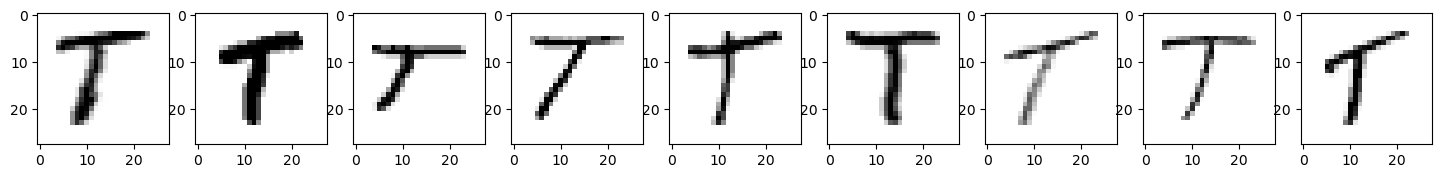

In [64]:
x,y = 1,9
display_letter(df,'I',[x,y])
display_letter(df,'L',[x,y])
display_letter(df,'T',[x,y])


T is overrepresented by a considerable margin compared to I:s. There is a potential risk of each I being identified as a T without a major hit in accuracy with the low quantity of I:s. Another measure should be used to avoid such a problem

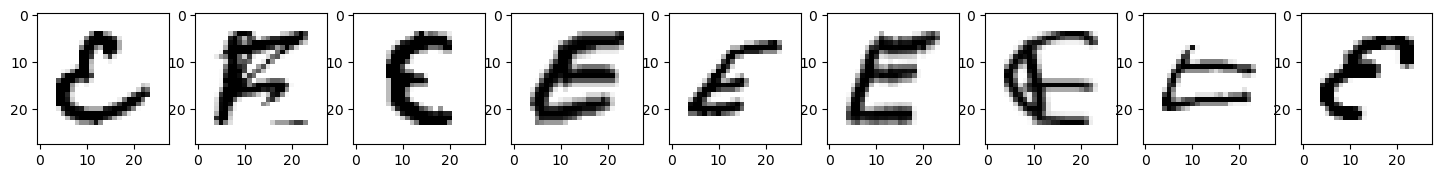

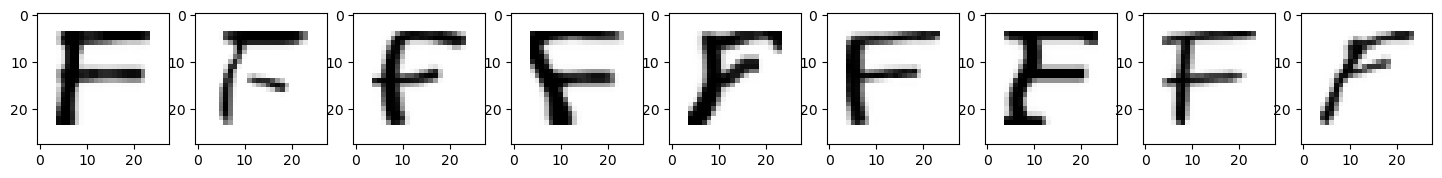

In [65]:
display_letter(df,'E',[1,y])
display_letter(df,'F',[1,y])

#### Check for duplicates

In [66]:
duplicates = df.duplicated()
duplicates.value_counts()

False    201095
True     171355
dtype: int64

A lot of duplicates exist let's make sure that they are indeed duplicates before dropping them

In [67]:
duplicates = df.loc[df.duplicated(keep=False)==True]
duplicates['0'].value_counts()

14    57038
18    47591
20    28173
2     22478
19    21593
15    18508
13    18202
0     12378
4     10802
17    10792
11    10720
24    10052
22     9960
3      9408
9      7799
1      7710
7      6488
23     5430
25     5287
6      5112
16     5062
10     4894
12     3926
21     3132
8       114
5        32
Name: 0, dtype: int64

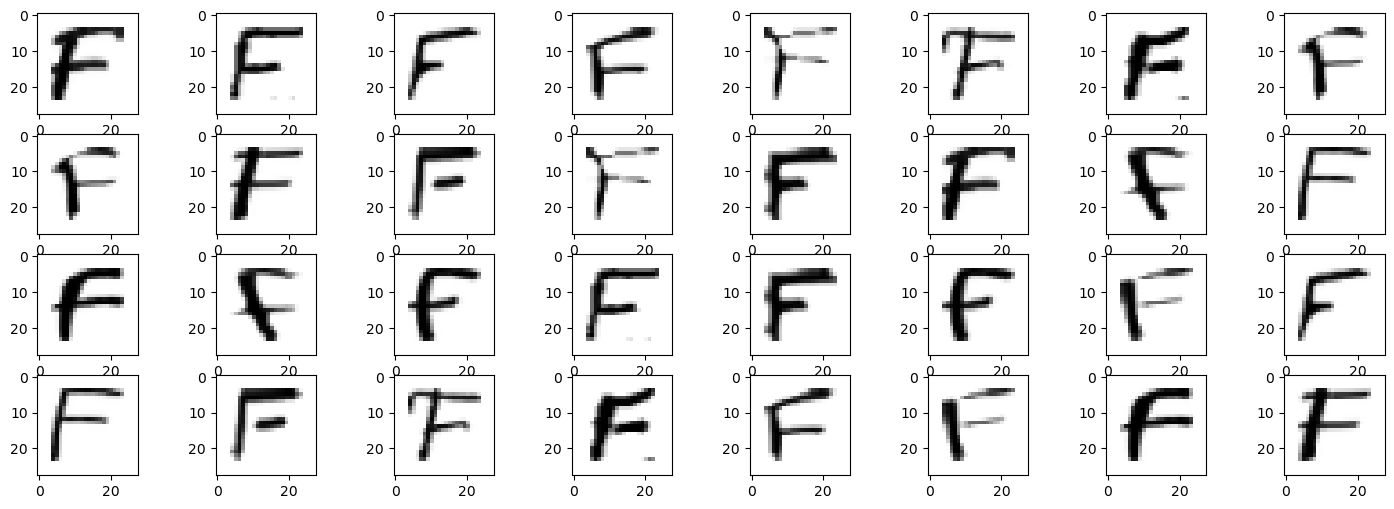

In [68]:
## F has few duplicates, the likelihood of the same appearing can be guaranteed
display_letter(duplicates,'F',[4,8])

They are unfortunately actual duplicates, we have to drop them and reexamine the distribution

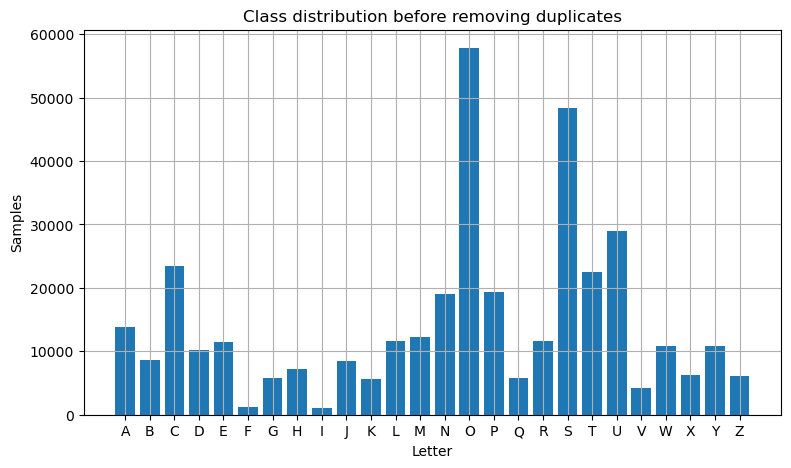

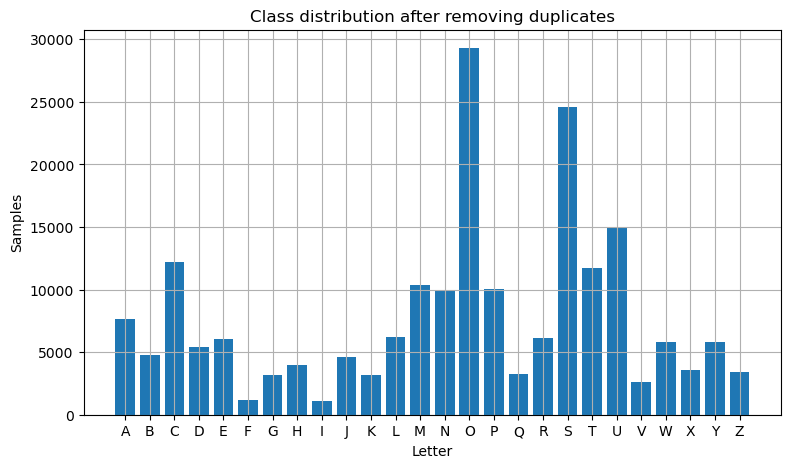

array([ 7680,  4804, 12170,  5430,  6039,  1147,  3206,  3974,  1061,
        4593,  3156,  6226, 10373,  9909, 29306, 10087,  3281,  6170,
       24622, 11698, 14921,  2616,  5804,  3557,  5833,  3432])

In [69]:
plot_dist(df['0'],"Class distribution before removing duplicates")
df.drop_duplicates(inplace=True)
plot_dist(df['0'],"Class distribution after removing duplicates")

In [83]:
df.shape[0]

201095

Fortunately most duplicates were of the overrepresented classes, the previous analysis holds true. The distribution has somewhat improved, but the quantity is almost halved

#### Summary of findings and conclusions
* **The data is severly skewed**
    * A different metric than accuracy needs to be used to measure the performance of any model
    * Integrating the dataset with another which has similar features could solve this balancing issue
* **The data varies greatly and has overlapping features**
    * We should pay extra attention to the performance of the model when classifying letters with overlapping features
* **Every letter is centered and 28x28 pixels**
    * When formatting input for practical use, the letter that is to be predicted should be processed in such a way that adheres to this standard 
      * Certain samples of F and E are indistinguishable for example
* **A lot of duplicates existed in the set**
  * We need to check for duplicates after integration as well
*** 

## Data balancing
Another skewed dataset was found on kaggle which has a partly complementary imbalance. These two datasets will be merged where ever the label count is below 10 0000 samples. This set is derived from the same source, duplicates may exist, it is therefore important to remove any occurences. 

https://www.kaggle.com/datasets/crawford/emnist?resource=download&select=emnist-balanced-test.csv

In [10]:
emnist = pd.read_csv('emnist-byclass.csv')
emnist.describe()

,35,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.466,0.467,0.468,0.469,0.470,0.471,0.472,0.473,0.474,0.475
count,697931.000000,697931.0,697931.0,697931.0,697931.000000,697931.000000,697931.000000,697931.000000,697931.000000,697931.000000,...,697931.000000,697931.000000,697931.000000,697931.000000,697931.000000,697931.0,697931.0,697931.0,697931.0,697931.0
mean,19.381598,0.0,0.0,0.0,0.000009,0.000878,0.004574,0.007309,0.007537,0.007203,...,0.000050,0.000047,0.000047,0.000350,0.000046,0.0,0.0,0.0,0.0,0.0
std,17.849639,0.0,0.0,0.0,0.006104,0.242795,0.789263,1.022130,1.055925,1.053377,...,0.041895,0.039501,0.039501,0.292068,0.038304,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,4.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,10.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,32.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,61.000000,0.0,0.0,0.0,5.000000,107.000000,215.000000,217.000000,247.000000,217.000000,...,35.000000,33.000000,33.000000,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


Findings from describe:
* there are more classes in this dataset (1-9, A-Z and a-z), our concern is only A-Z
* The columns are not named exactly like the previous set
* The pixel values are formatted similarly, and the dimensions are the same

All rows with the coressponding label for A-Z will be selected

In [11]:
#Selecting and relabelling
emnistAZ = emnist.loc[emnist['35'].isin(range(10,36))].copy() # 10-36 coressponds to A-Z in the data set
emnistAZ['35'] += -10 # Since the dataset contained digits which got a class label value preceeding A-Z, every label is shifted by 10. 

#Renaming 
keys = list(emnistAZ.keys())
vals = list(df.keys())
rename_map = dict(zip(keys,vals))
emnistAZ.rename(columns = rename_map,inplace=True)
emnistAZ.describe()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
count,188957.000000,188957.0,188957.0,188957.0,188957.000000,188957.000000,188957.000000,188957.000000,188957.000000,188957.000000,...,188957.000000,188957.0,188957.0,188957.000000,188957.000000,188957.0,188957.0,188957.0,188957.0,188957.0
mean,12.842091,0.0,0.0,0.0,0.000032,0.003122,0.015919,0.025355,0.026392,0.023709,...,0.000185,0.0,0.0,0.001291,0.000169,0.0,0.0,0.0,0.0,0.0
std,6.714312,0.0,0.0,0.0,0.011730,0.464631,1.485623,1.923173,1.999525,1.903154,...,0.080517,0.0,0.0,0.561317,0.073615,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,8.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,14.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,18.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,25.000000,0.0,0.0,0.0,5.000000,107.000000,215.000000,217.000000,247.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


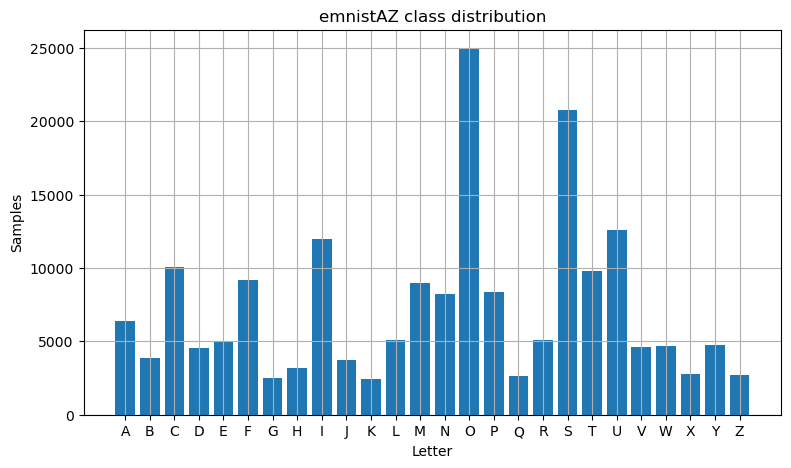

array([ 6407,  3878, 10094,  4562,  4934,  9182,  2517,  3152, 11946,
        3762,  2468,  5076,  9002,  8237, 24983,  8347,  2605,  5073,
       20764,  9820, 12602,  4637,  4695,  2771,  4743,  2700])

In [12]:
plot_dist(emnistAZ['0'],'emnistAZ class distribution')

Integrating with this set will yield 10 times more I's and F's, as well as a healthy increase for all other underrepresented letters. Every letter below 10 000 samples will be integrated

In [73]:
integrateLst =[]
threshhold = 10_000
labelCount = df['0'].value_counts().to_dict()
for label in labelCount.keys():
    if labelCount[label] < threshhold:
        integrateLst.append(label)
integrateLst

[13, 0, 11, 17, 4, 24, 22, 3, 1, 9, 7, 23, 25, 16, 6, 10, 21, 5, 8]

In [75]:
emnistIntegrate = emnistAZ.loc[emnistAZ['0'].isin(integrateLst),:].copy()
emnistIntegrate['0'].value_counts() # All labels intended for integration have been collected

8     11946
5      9182
13     8237
0      6407
11     5076
17     5073
4      4934
24     4743
22     4695
21     4637
3      4562
1      3878
9      3762
7      3152
23     2771
25     2700
16     2605
6      2517
10     2468
Name: 0, dtype: int64

### A shallow look at the dataset
The following part will see if the dataset is fit for integration as is, or if some manipulation of the data is required

N


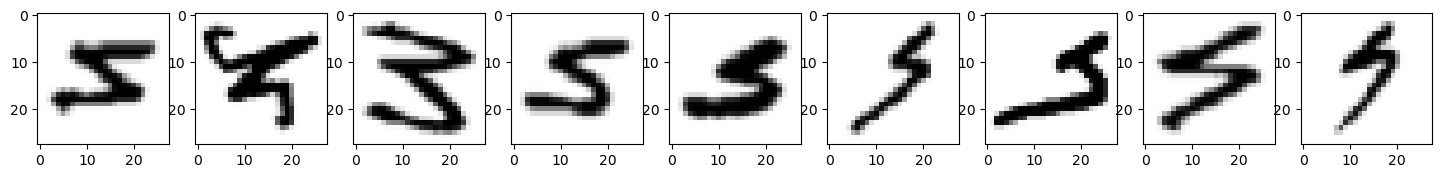

A


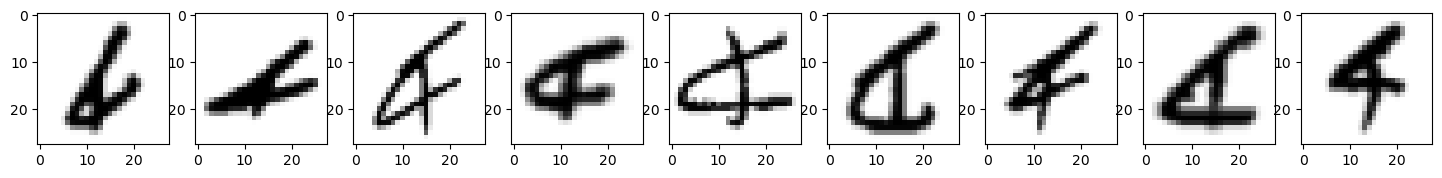

L


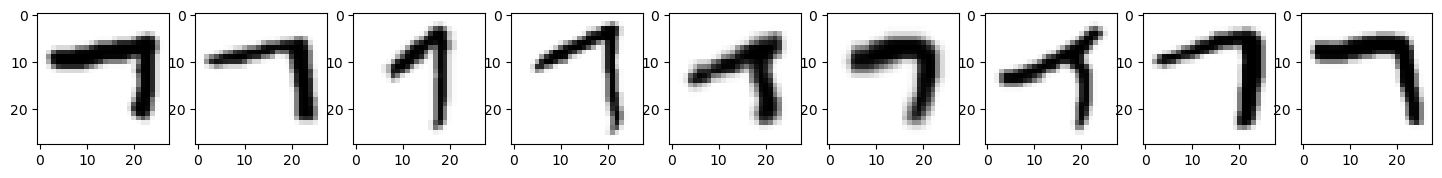

R


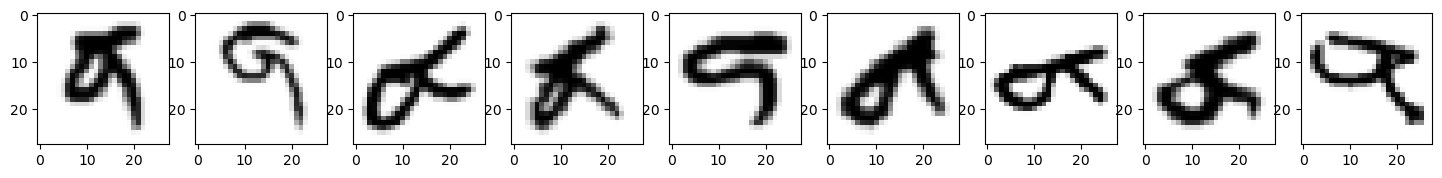

E


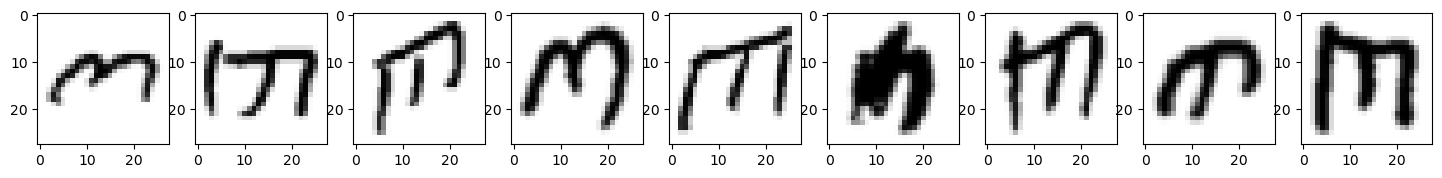

Y


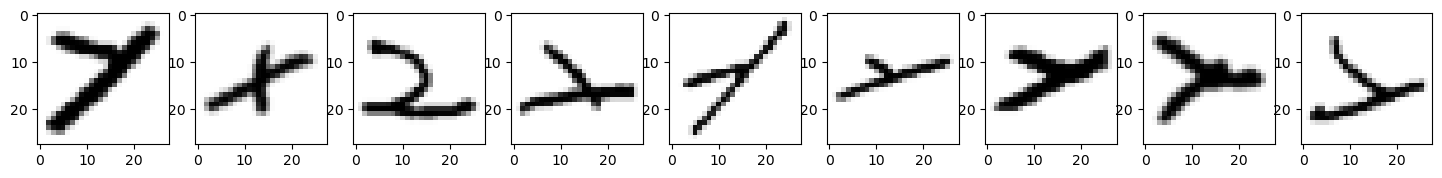

W


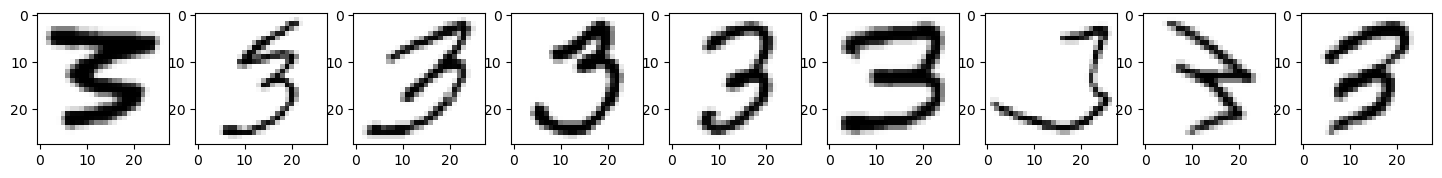

D


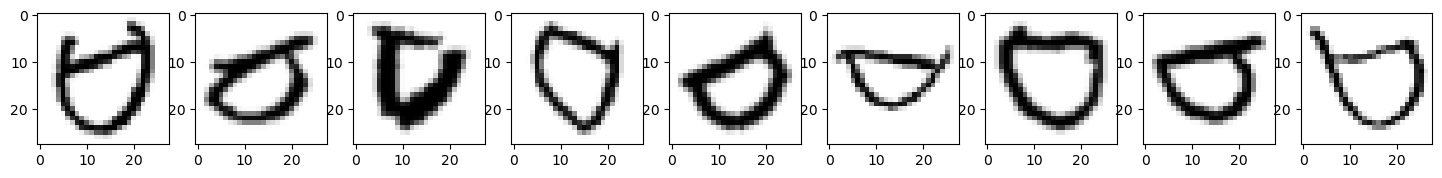

B


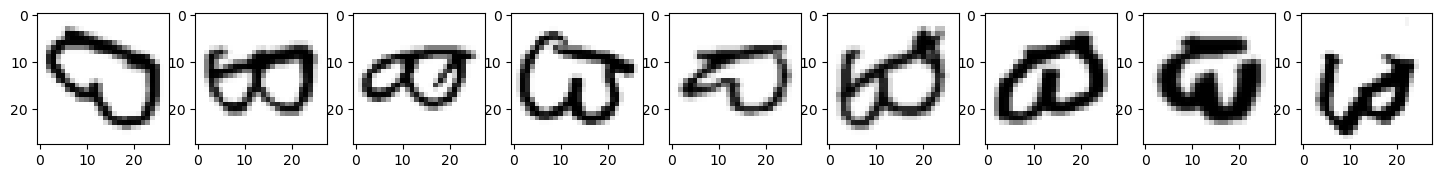

J


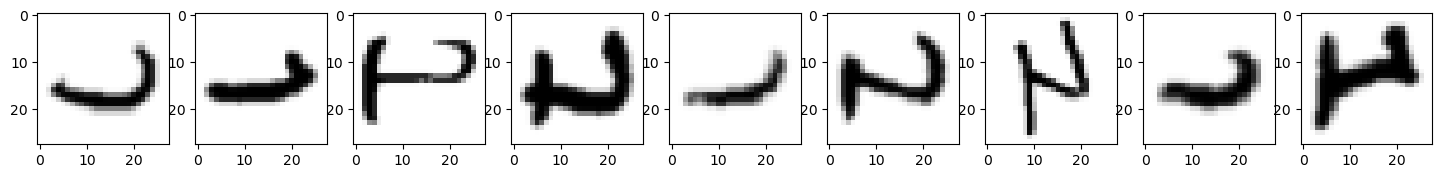

H


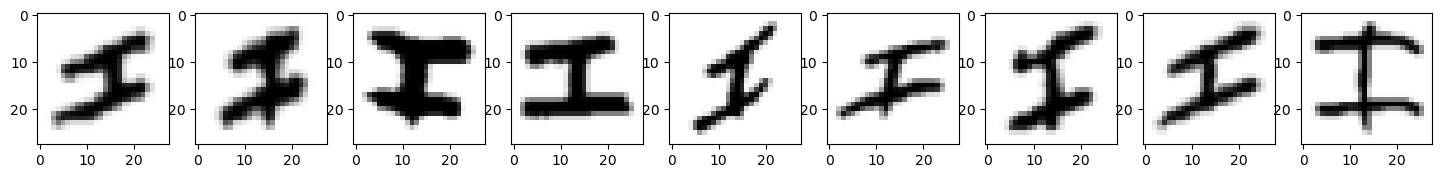

X


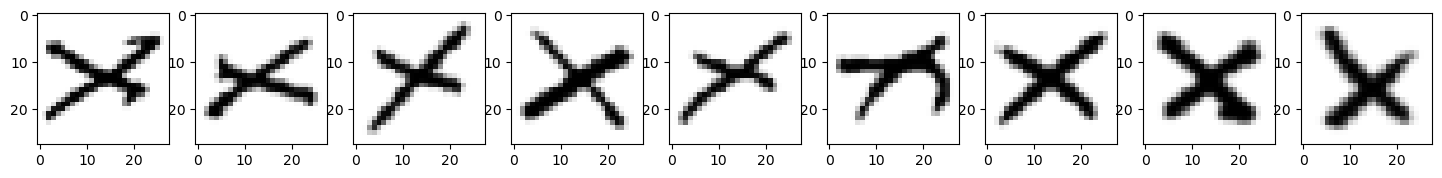

Z


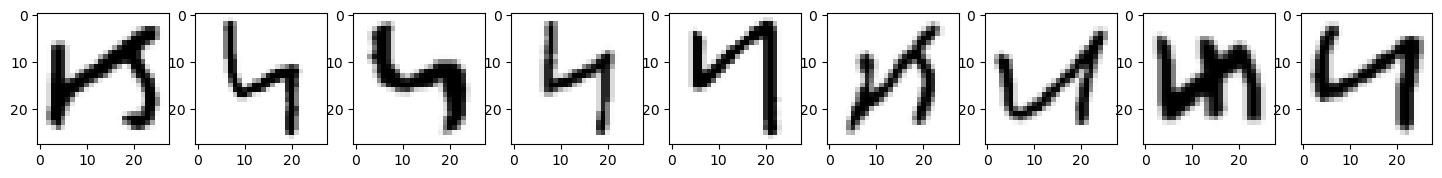

Q


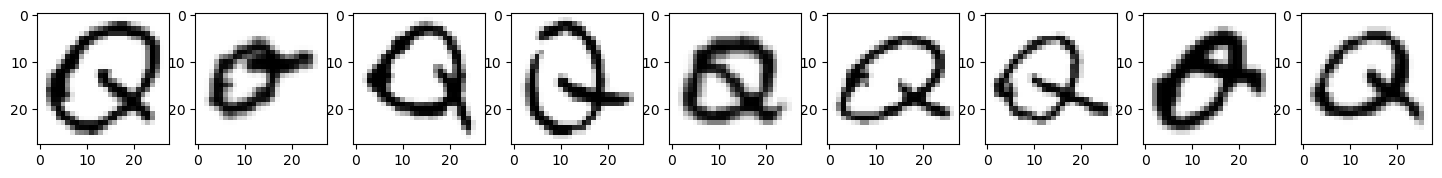

G


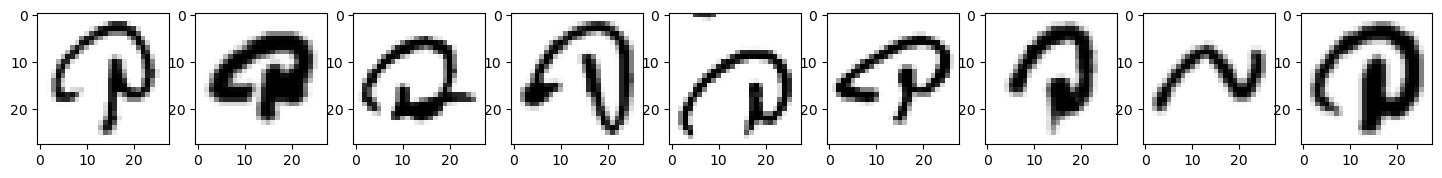

K


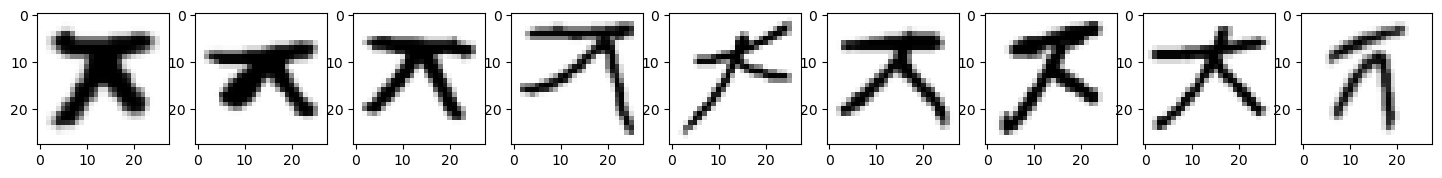

V


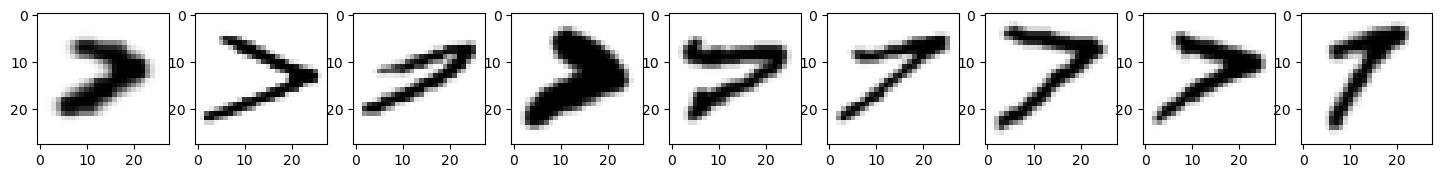

F


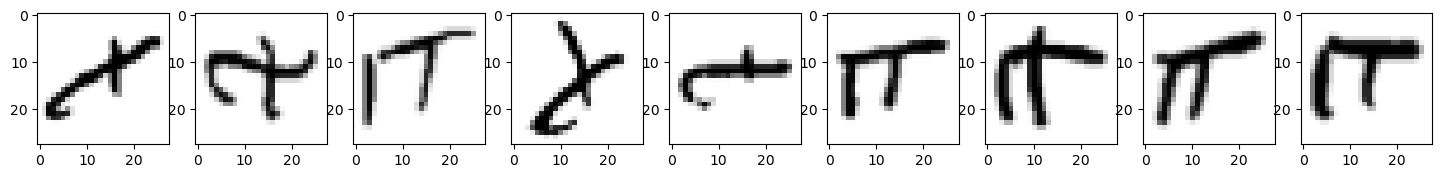

I


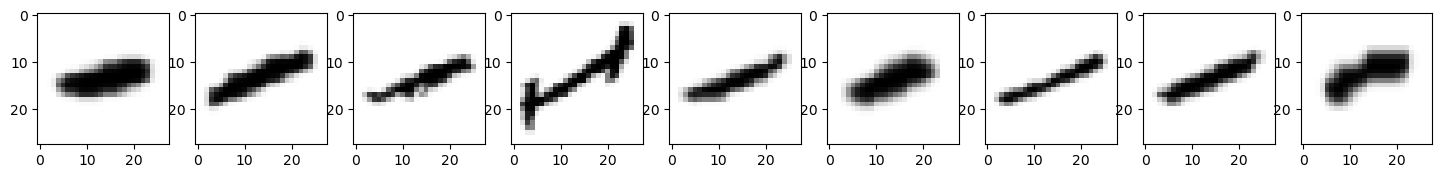

In [76]:
for letter in integrateLst:
    print(chr(letter+ord('A')))
    display_letter(emnistAZ,chr(letter+ord('A')),[1,9])


All the letters barring Q are rotated 90 degrees and flipped. Transposing the columns might solve this issue

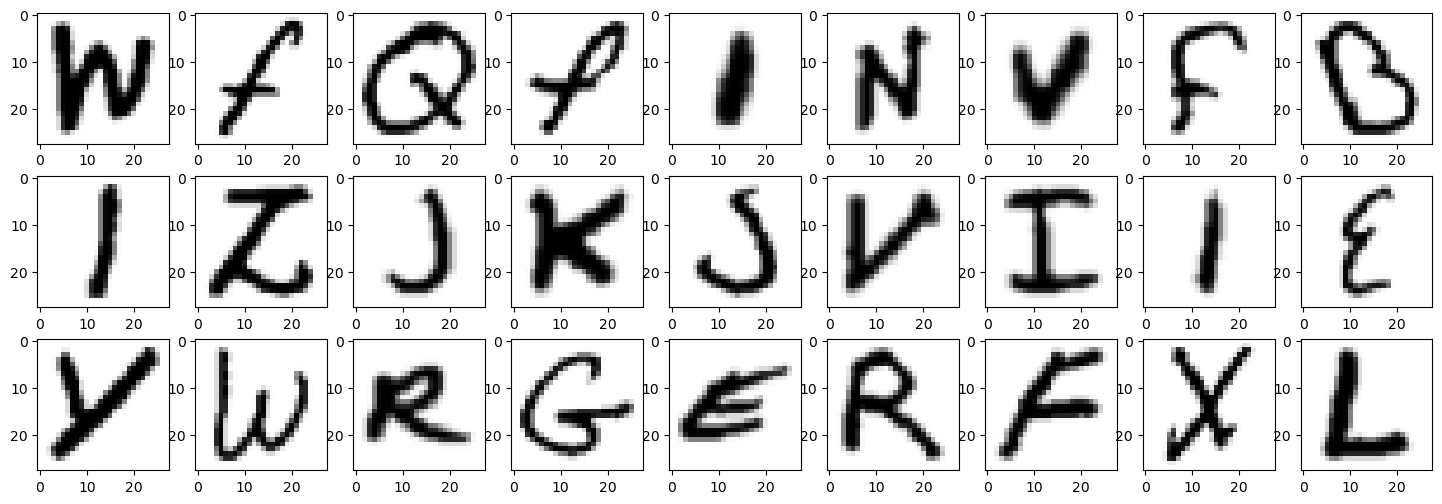

In [77]:
idf = emnistAZ.loc[emnistAZ['0'].isin(integrateLst)]
idf = idf.drop(columns=['0']) # The labels cannot be included in the reshape unfortunatley
idf = np.reshape(idf.values,(idf.shape[0],28,28)) #Need to reshape the data in order for transpose to work properly.
x,y =3,9
fig, ax = plt.subplots(x,y, figsize = (18,6))
axes = ax.flatten()

for i in range(x*y):
    pic  = idf[i].transpose()
    axes[i].imshow(pic, cmap="binary")
plt.show()


Transposing solves the rotation issue, the transposed columns need to be reshaped again, rejoined with their respective label and integrated

It is important to note that this dataset, very much like the other set seems to contain some lowercase letters (especially for F)

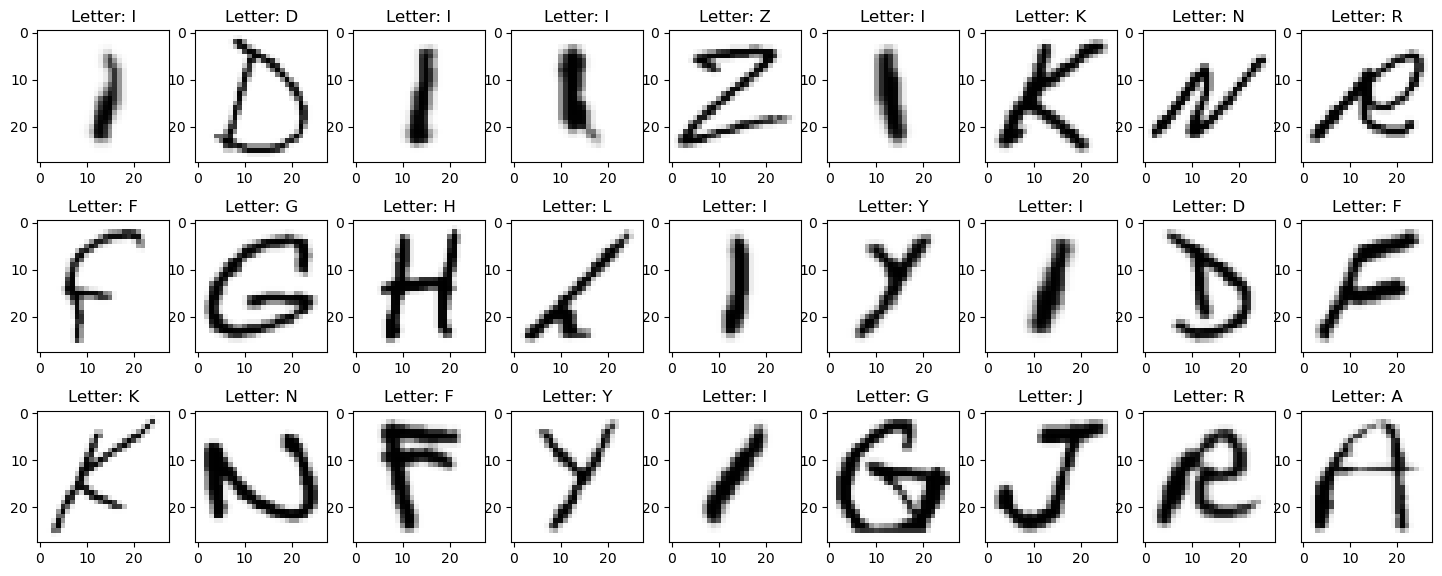

In [78]:
emnistIntegrate = emnistAZ.loc[emnistAZ['0'].isin(integrateLst),:].copy() #This row is reassigned to avoid transposing twice (nullifying the transposition)
for ind,row in emnistIntegrate.iterrows():
    rowRe = np.reshape(row['0.1':].values,(28,28)) #Reshape to allow for transposing
    rowRe = rowRe.transpose()
    rowRe = np.reshape(rowRe,(28*28)) #Restore the previous shape of the data after transposing
    row['0.1':] = rowRe #update row which contains the label with the manipulated data
    emnistIntegrate.loc[ind,:] = row #update the dataframe

display_rand_letters(emnistIntegrate)

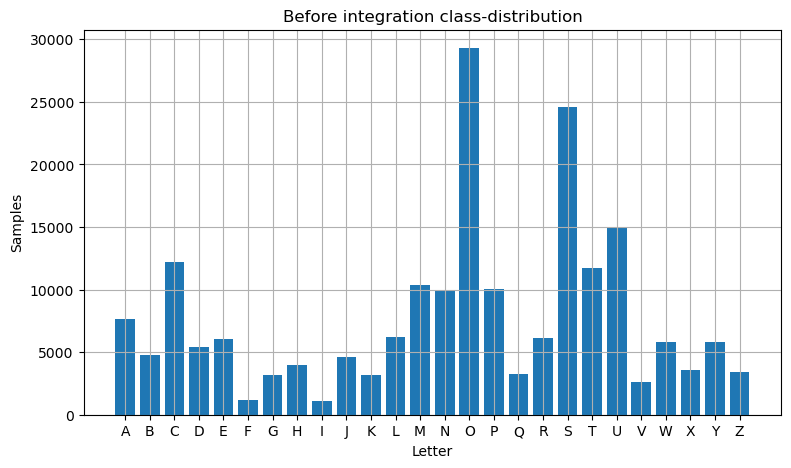

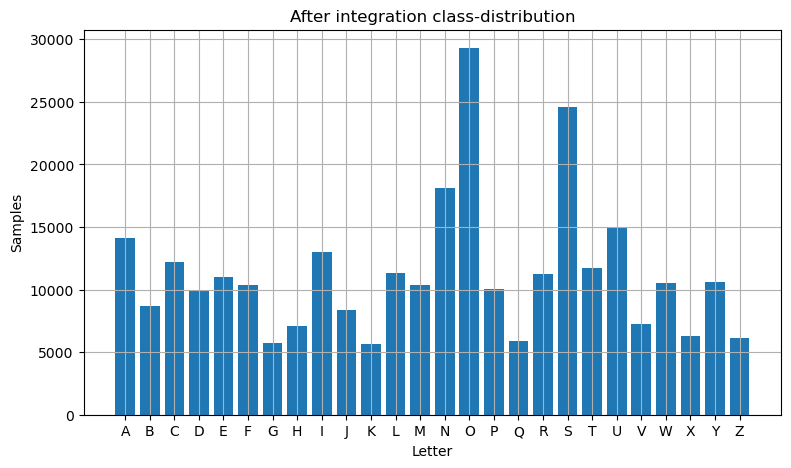

In [79]:
dataset = pd.concat([emnistIntegrate,df])
dataset.drop_duplicates(inplace=True)
p= plot_dist(df['0'],'Before integration class-distribution') #Assigned p and d to avoid unnecessary output (plot_dist returns the value count of every letter)
d=plot_dist(dataset['0'],'After integration class-distribution')

In [82]:
dataset.shape[0]

294439

Every class has more than 5 000 samples but a few letters are severly over represented. To further balance the data, class weights will be used to boost and supress certain samples.

Using sklearns compute_class_weight generates weights for each class based on sample count

In [86]:
from sklearn.utils import class_weight
#The models require listlike object for weights so the weights are zipped and made into a dict. 
weights = dict(zip(np.unique(dataset['0']), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(dataset['0']),y=dataset['0']))) 
weights

{0: 0.803902670765736,
 1: 1.304374213669307,
 2: 0.9305322040326148,
 3: 1.1334778223478053,
 4: 1.0320401825459695,
 5: 1.0963865740223568,
 6: 1.978783316980067,
 7: 1.589191260605799,
 8: 0.8706524888965114,
 9: 1.3554251254430787,
 10: 2.013616095852938,
 11: 1.001997604236146,
 12: 1.0917359416829193,
 13: 0.6240811706754614,
 14: 0.38642520040527273,
 15: 1.1226902868124242,
 16: 1.9239852060952978,
 17: 1.007255796769272,
 18: 0.4599373293427391,
 19: 0.9680780409537462,
 20: 0.7589690317724632,
 21: 1.5613645282058353,
 22: 1.0786338625656655,
 23: 1.7895981231158222,
 24: 1.0707807226812522,
 25: 1.8467998896081088}

### HOG exploration
Being fairly unfamiliar with HOGs, experimentation was conducted to see which settings yielded the most desirable results. 
#### Goals
* Find settings for HOG image transformation which likens the image found on (https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features)



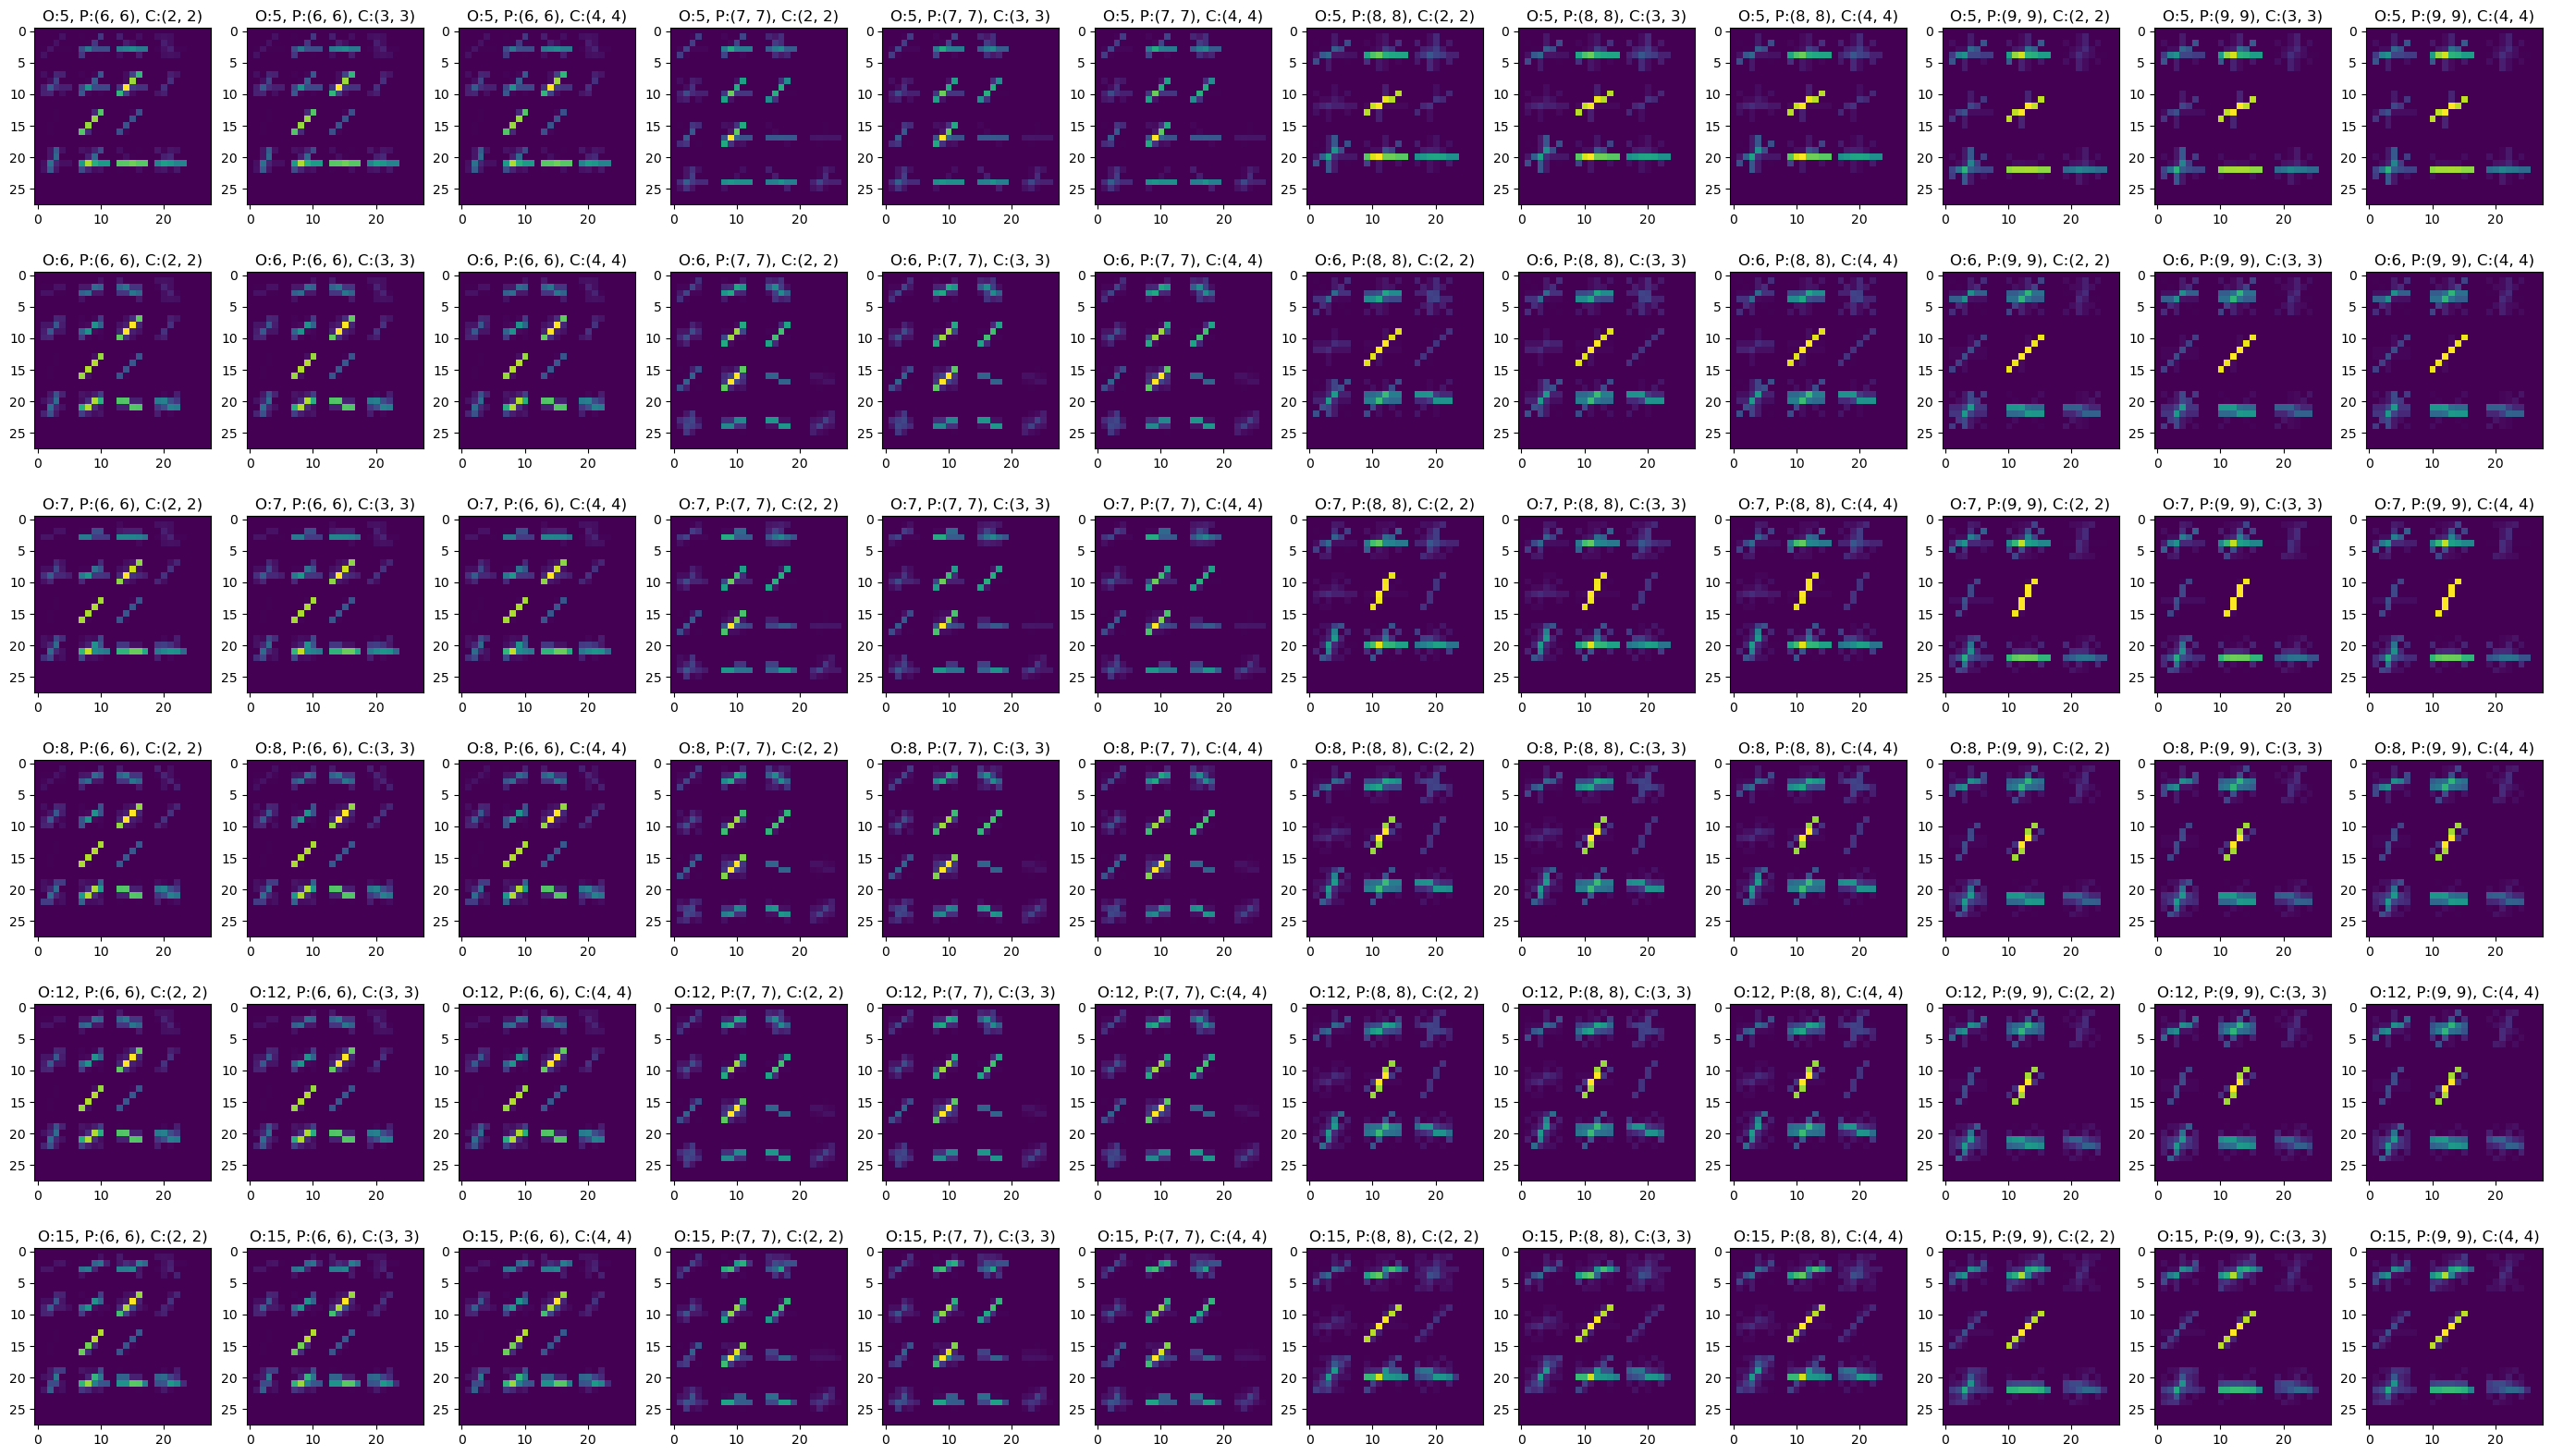

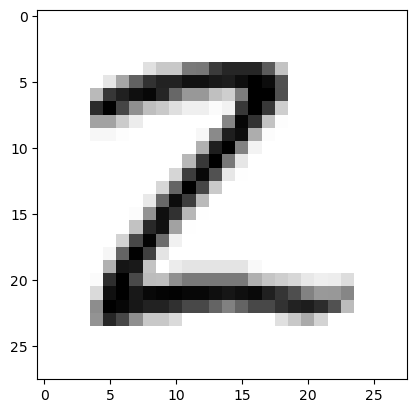

In [87]:

X = np.reshape(df.loc[:,'0.1':].values, (df.shape[0],28,28))
# The following lists contain various settings that were tested
orientation = [5,6,7,8,12,15]
pixels = [(6,6),(7,7),(8,8),(9,9)]
cells = [(2,2),(3,3),(4,4)]

fig, ax = plt.subplots(len(orientation),len(pixels)*len(cells), figsize = (35,20))
axes = ax.flatten()

combo = []
# Creates every setting combination possible with the lists
for i in range(len(orientation)):
    for j in range(len(pixels)):
        for k in range (len(cells)):
            combo.append((orientation[i],pixels[j],cells[k]))   
index = 200_094 #use this to change letter
# Generates an image for each of the setting combinations
for i,ax in enumerate(axes):
    ax.set_title(f"O:{combo[i][0]}, P:{combo[i][1]}, C:{combo[i][2]}")
    fd,im = hog(X[index],
                orientations=combo[i][0],
                pixels_per_cell=combo[i][1],
                cells_per_block=combo[i][2], 
                block_norm='L2', 
                visualize=True)
    axes[i].imshow(im)
fig, ax = plt.subplots()
ax.imshow(X[index], cmap="binary")
plt.show()



When a setting combination with potential was identified, a closer look was conducted by selecting a random sample of letters and applying said settings. 

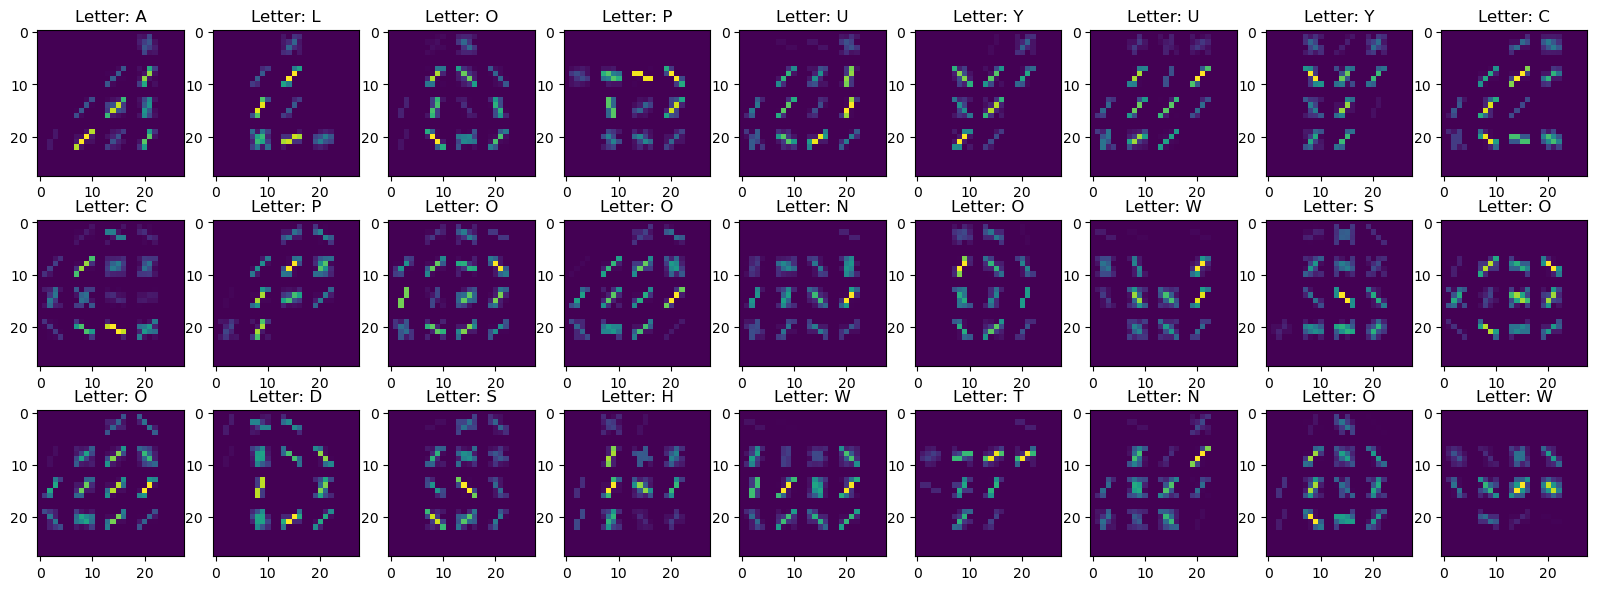

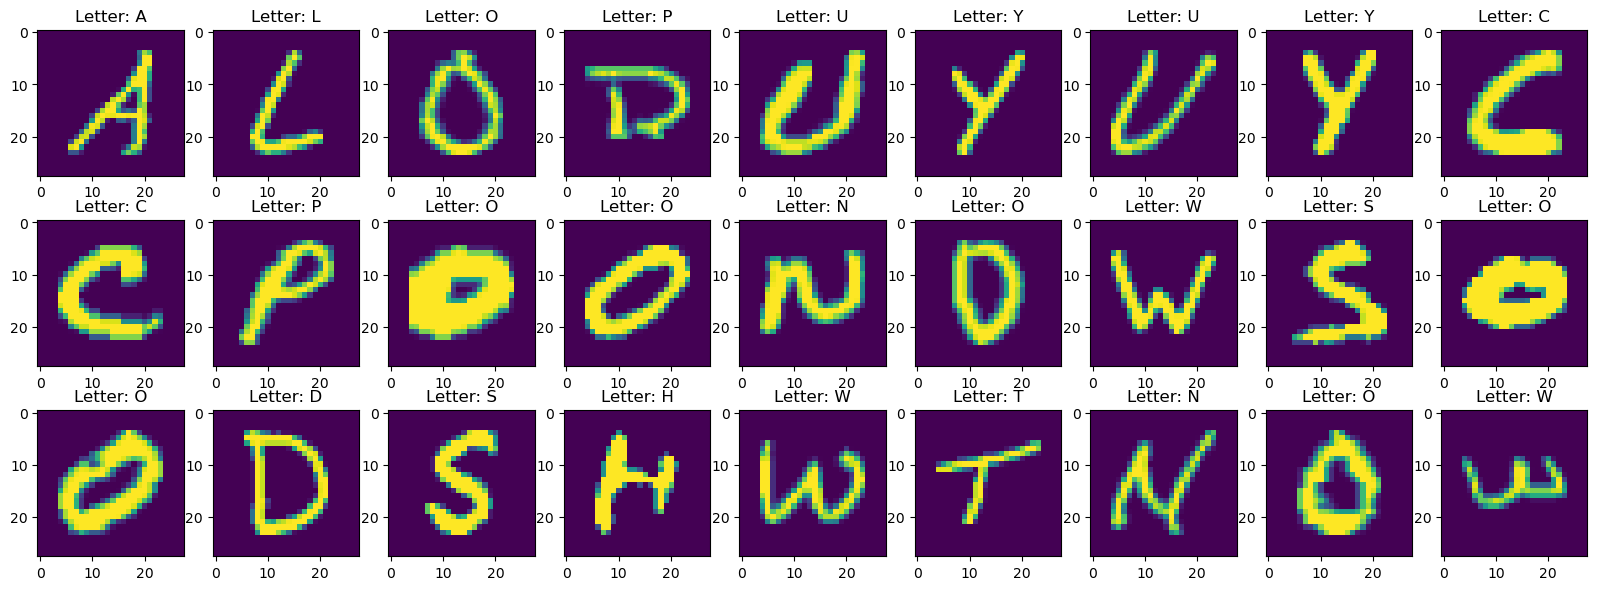

In [88]:
shuff = shuffle(df)
x,y = 3,9
fig, ax = plt.subplots(x,y, figsize = (20,7))
axes = ax.flatten()
ims = []
for i,ax in enumerate(axes):
    im = shuff.iloc[i]
    ims.append(im)
    letter = chr(im[0]+ord('A'))
    ax.set_title(f"Letter: {letter}")
    im = np.reshape(im[1:].values, (28,28))
    fd,im = hog(im,
                orientations=12,
                pixels_per_cell=(6,6),
                cells_per_block=(4,4), 
                block_norm='L2', 
                visualize=True)
    axes[i].imshow(im)
plt.show()

# Used to see which letters are being transformed
x,y = 3,9
fig, ax = plt.subplots(x,y, figsize = (20,7))
axes = ax.flatten()
for i,ax in enumerate(axes):

    letter = chr(ims[i][0]+ord('A'))
    ax.set_title(f"Letter: {letter}")
    ims[i] = np.reshape(ims[i][1:].values, (28,28))
    axes[i].imshow(ims[i])
plt.show()

Upon testing the following settings were identified as somewhat similar:
* Orientation: 12
* cells per block: 4,4
* pixels per cell: 6,6

 To confirm the settings, we contacted Hüseyin Kusetogullari to make sure that this is indeed how a HOG should look like.

***


## Model creation
### Goals
* Create a function which generates convolutional neural network to use for training, testing and, comparing the two models
* Create a function to generate a SVM classifier to use for training, testing, and, comparing the two models

The CNN layer set-up is the same as described in Tensor-flows documentation at https://www.tensorflow.org/tutorials/images/cnn.

Minor modifications to output and input were made to suit the data

In [89]:
# Different settings are used, the best model will be used in the paper. 
def gen_cnn():
    model = keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) #inputlayer
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten()) ## Start of classification layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(26,activation = 'softmax'))
    model.compile(optimizer=keras.optimizers.Adam(), 
                  loss=keras.losses.SparseCategoricalCrossentropy(), #The current lossfunction is appropriate for non-binary classification where the labels are integers. 
            metrics = ['accuracy'])#This is the case for our dataset, there are multiple classes and all labels are integers
    return model

def gen_svm(prob = False, cores = 0,weights=None):
    return svm.SVC(probability= prob,class_weight=weights) #Might be seen as unecessary and I would agree. This solely exists in case we decide to tweak parameters.


                                        

## Training with stratified k-folds cross-validation
### Goals:
* Train and test each model on the same folds using 10-folds
* Store resulting metrics (F1-score, accuracy and training time)

In [90]:
from sklearn.model_selection import StratifiedKFold
from skimage.feature import hog
from sklearn import svm
import time
X,y = dataset.loc[:,'0.1':],dataset['0']

t2 = time.time()
letter_wise_results = {"cnn":[],"svm":[]}
preds = {"cnn":[],'svm':[], 'target':[]}
training_time = {'cnn':[],"svm":[]} 
tenfold = StratifiedKFold(n_splits=10)
accuracies = {"cnn":[],"svm":[]}
f1score = {"cnn":[],"svm":[]}
modelsK = {"cnn":[],"svm":[]}
#Trains and tests data on each fold. Measuring trainingtime, accuracy, and F-score 
for train_i, test_i in tenfold.split(X, y):
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    X_train = np.reshape(X_train.values,(X_train.shape[0],28,28))
    X_test = np.reshape(X_test.values,(X_test.shape[0],28,28))

    hog_train = []
    #Generates HOG data for our HOG SVM
    for img in X_train:
        fd= hog(img,orientations=12,pixels_per_cell=(6,6),cells_per_block=(4,4), block_norm='L2', visualize=False) 
        hog_train.append(fd)
    hog_test = []
    for img in X_test:
        fd= hog(img,orientations=12,pixels_per_cell=(6,6),cells_per_block=(4,4), block_norm='L2', visualize=False) 
        hog_test.append(fd)
    hog_test = np.array(hog_test,dtype="float32")
    hog_train = np.array(hog_train,dtype="float32")
    
    t0 = time.time() #Measures time before training
    hogSvmClf = gen_svm(weights=weights)
    hogSvmClf.fit(hog_train,y_train)
    training_time['svm'].append(time.time()-t0) # gets time before training for HOG SVM
    
    hog_ypred = hogSvmClf.predict(hog_test)
    
    letter_wise_results['svm'].append(metrics.classification_report(hog_ypred,y_test,output_dict=True))
    accuracies['svm'].append(metrics.accuracy_score(hog_ypred,y_test))
    f1score['svm'].append(metrics.f1_score(hog_ypred,y_test,average = 'weighted'))
    

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)
    cnn = gen_cnn()
    t0 = time.time()
    history = cnn.fit(X_train, y_train, epochs=15,
                        validation_data=(X_val,y_val),
                        batch_size=64, #A batchsize of 64 was chosen as a lower batchsize might lead to taking a dominating role
                        class_weight=weights,verbose=0)
    training_time['cnn'].append(time.time()-t0)
    ypred = cnn.predict(X_test,verbose=0)
    predicted = []
    for i in ypred:
        predicted.append(np.argmax(i))
    letter_wise_results['cnn'].append(classification_report(predicted,y_test,output_dict=True))
    accuracies['cnn'].append(accuracy_score(predicted,y_test))
    f1score['cnn'].append(metrics.f1_score(predicted,y_test,average = 'weighted'))

    modelsK["cnn"].append(cnn)
    preds["cnn"].append(ypred)
    #modelsK["svm"].append(hogSvmClf)
    #preds["svm"].append(hog_ypred)
    preds["target"].append(y_test)
        

1154.8116204738617
1151.4291429519653
1141.611322402954
1142.8941419124603
1146.8581900596619
1158.6397469043732
1151.146115064621
1144.152595758438
1219.2498869895935
1264.745103597641


In [91]:
pd.DataFrame(accuracies).to_csv("accuracies.csv")
pd.DataFrame(f1score).to_csv('fscore.csv')
pd.DataFrame(training_time).to_csv('time.csv')

***
### Evaluation and testing
Since there are only two groups from different populations the following pair-wise tests can be conducted to test for a statistical significance in performance
* Independent-samples t-test
* Mann-Whitney U test

The first-named test is parametric which requires us to prove three attributes of the sets:
1. Independence: every data point is sampled independently (yes)
2. Normality: data follows a normal distribution (unknown)
3. Homoscedasticity: the variance among data groups is similar (unknown) 

To test for the two aforementioned ones a Shapiro-Wilks test and Levene's test for respective criterion.

If either of the criterions are not met then a non-parametric test, namely the Mann-Whitney U test, will be used instead.

In [146]:
import scipy.stats as scp

def get_results(pvalues,passmessage,rejectmessage): #Generates our messages for the tests
    for metric in pvalues.keys():
        if pvalues[metric] < 0.05:
            print(f"{metric} " + rejectmessage)
        else:
            print(f"{metric} "+ passmessage)
        print(f"p-value: {pvalues[metric]}\n")        
        

pvalues = {'fscore':0,'accuracy':0,'training time':0}
pvalues['accuracy'] = scp.levene(accuracies['svm'], accuracies['cnn'])[1]
pvalues['fscore'] = scp.levene(f1score['svm'], f1score['cnn'])[1]
pvalues['training time']= scp.levene(training_time['svm'],training_time['cnn'])[1]
get_results(pvalues=pvalues,passmessage="passed Levene's", rejectmessage="did not pass Levene's",)

        
pvalues['accuracy'] = (scp.shapiro(accuracies['svm'])[1],scp.shapiro(accuracies['cnn'])[1])
pvalues['fscore'] = (scp.shapiro(f1score['svm'])[1],scp.shapiro(f1score['cnn'])[1])
pvalues['training time']= (scp.shapiro(training_time['svm'])[1],scp.shapiro(training_time['cnn'])[1])    

for metric in pvalues.keys():
    if pvalues[metric][0] < 0.05 and pvalues[metric][1] < 0.05:
        print(f"""{metric} does not follow a normal distribution\n
              p-value (svm,cnn): {pvalues[metric]}\n""")
    else:
        print(f"""{metric} follows a normal distribution\n
              p-value (svm,cnn): {pvalues[metric]}\n""")

fscore passed Levene's
p-value: 0.4413924625334834

accuracy passed Levene's
p-value: 0.42881830335474036

training time passed Levene's
p-value: 0.4309204812997216

fscore follows a normal distribution

              p-value (svm,cnn): (0.5056099891662598, 0.7830416560173035)

accuracy follows a normal distribution

              p-value (svm,cnn): (0.517278254032135, 0.7794696688652039)

training time follows a normal distribution

              p-value (svm,cnn): (0.803795576095581, 0.00027624244103208184)



In [152]:
# In case non-parametric
npPvalues = {} 
npPvalues['accuracy'] = scp.ttest_ind(accuracies['svm'], accuracies['cnn'])[1]
npPvalues['fscore'] = scp.ttest_ind(f1score['svm'], f1score['cnn'])[1]
npPvalues['training time']= scp.ttest_ind(training_time['svm'],training_time['cnn'])[1]
get_results(pvalues=npPvalues,passmessage="does not have a statistically significant difference", rejectmessage="has a statistically significant difference")

accuracy does not have a statistically significant difference
p-value: 0.8169757288002353

fscore does not have a statistically significant difference
p-value: 0.801390662827649

training time has a statistically significant difference
p-value: 1.0879544854994253e-17



In [153]:
# Tests if SVM had values lower than CNN
npPvalues['accuracy'] = scp.ttest_ind(accuracies['svm'], accuracies['cnn'],alternative='less')[1]
npPvalues['fscore'] = scp.ttest_ind(f1score['svm'], f1score['cnn'],alternative='less')[1]
npPvalues['training time']= scp.ttest_ind(training_time['svm'],training_time['cnn'],alternative='less')[1]
get_results(pvalues=npPvalues,passmessage="does not have a statistically significant inequality (SVM<CNN)", rejectmessage="has a statistically significant inequality (SVM<CNN)")

accuracy does not have a statistically significant inequality (SVM<CNN)
p-value: 0.5915121355998825

fscore does not have a statistically significant inequality (SVM<CNN)
p-value: 0.5993046685861755

training time has a statistically significant inequality (SVM<CNN)
p-value: 5.439772427497127e-18



### Conclusion
* H0_1 cannot be rejected, as CNN did not have a statistically significantly higher f1-score or accuracy rate.
* H0_2 can be rejected as CNN has a significantly higher training time than SVM

HOG SVM performed the task both faster and better than CNN in these folds. This could stem from the sample size that each fold has. A convolutional neural network requires significant amounts of data and could have possibly suffered from the fold size. 

The time comparison is partly stained by the fact that sklearn the model whilst tensorflow can use the gpu. (https://scikit-learn.org/stable/computing/parallelism.html,https://www.tensorflow.org/guide/gpu#:~:text=TensorFlow%20supports%20running%20computations%20on,devices%2C%20including%20CPU%20and%20GPU.)
***
### A letterwise examination

In [168]:
print("CNN weighted average")
count = 1
for i in letter_wise_results["cnn"]:
    print(f"{count}. is {i['weighted avg']['f1-score']}")
    count+=1
count = 1
print("\nCNN macro average")
for i in letter_wise_results["cnn"]:
    print(f"{count}. {i['macro avg']['f1-score']}")
    count+=1
diff = 0
for i in letter_wise_results["cnn"]:
    diff += i['weighted avg']['f1-score']-i['macro avg']['f1-score']

print("\naverage difference is")
diff/10




CNN weighted average
1. is 0.9833433805038052
2. is 0.9798091894218113
3. is 0.979478005624441
4. is 0.9802820467593782
5. is 0.9755361545989508
6. is 0.9758299654495108
7. is 0.9781076773633529
8. is 0.9808746282091505
9. is 0.9792884613573742
10. is 0.9768811202129847

CNN macro average
1. 0.980982420524565
2. 0.9765409975517554
3. 0.9776899402723368
4. 0.9779694944111578
5. 0.9735361261969108
6. 0.9732951966627444
7. 0.9761151514799502
8. 0.9798477501171375
9. 0.9775848999794676
10. 0.9752789556676548

average difference is


0.0020589696637079435

In [169]:

print("SVM weighted average")
count = 1
for i in letter_wise_results["svm"]:
    print(f"{count}. is {i['weighted avg']['f1-score']}")
    count+=1
count = 1
print("\nSVM macro average")
for i in letter_wise_results["svm"]:
    print(f"{count}. {i['weighted avg']['f1-score']}")
    count+=1

diff = 0
for i in letter_wise_results["svm"]:
    diff += i['weighted avg']['f1-score']-i['macro avg']['f1-score']
print("\naverage difference is")
diff/10


SVM weighted average
1. is 0.9810611631713347
2. is 0.9815098055009922
3. is 0.9776422532877995
4. is 0.9786951356992986
5. is 0.9781798543099507
6. is 0.9804745830416902
7. is 0.9787237872104793
8. is 0.9808381554974769
9. is 0.9786545358054686
10. is 0.9760515626366562

SVM macro average
1. 0.9810611631713347
2. 0.9815098055009922
3. 0.9776422532877995
4. 0.9786951356992986
5. 0.9781798543099507
6. 0.9804745830416902
7. 0.9787237872104793
8. 0.9808381554974769
9. 0.9786545358054686
10. 0.9760515626366562

average difference is

0.0018937314929014294
      


The weighted average seems to better by on average 0.2% points for each algorithm. 

In [ ]:
from sklearn import metrics
cfm_results = []

fig, ax = plt.subplots( figsize=(15,15)) 
metrics.ConfusionMatrixDisplay.from_predictions(y_pred = preds['svm'][0], y_true = preds['target'][0],ax=ax,normalize = 'true',display_labels = ticks,cmap = 'Blues',values_format = '.1%',colorbar=False)

The SVM performed best on T with 99.7% accuracy, whilst the worst performin was Es which were regularly (1.5%) mistaken as an F. The model struggled also with distinguishing Q:s and O:s.  

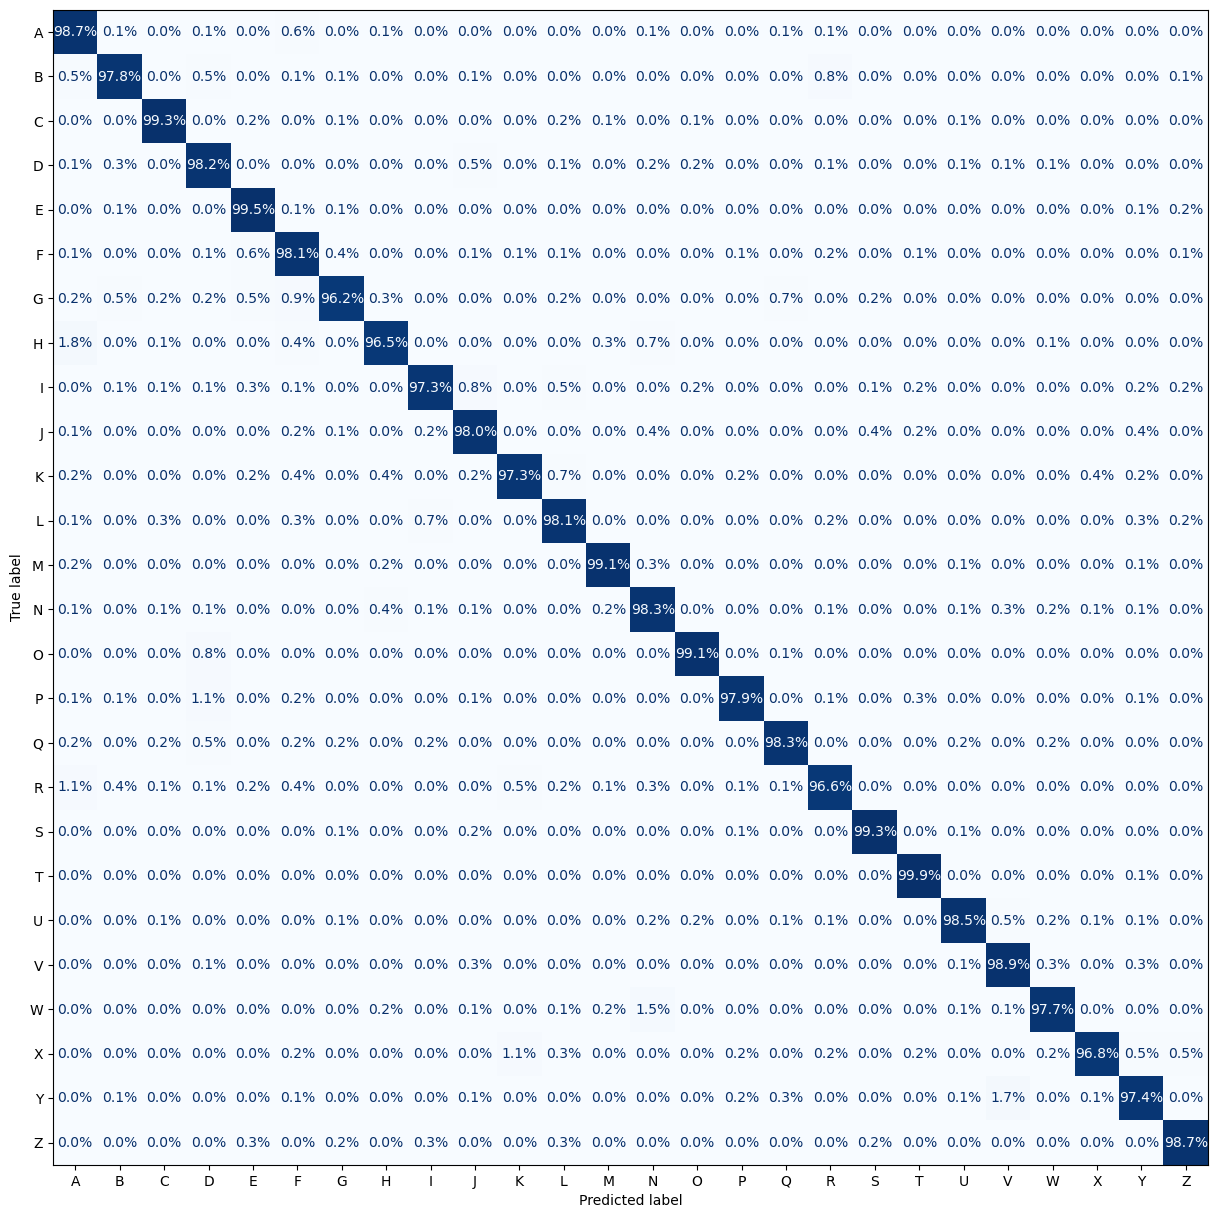

In [129]:
from sklearn import metrics
cfm_results = []
for i in preds['cnn'][0]: #CNN gives a list of probabilities, i select the likeliest for as the predicted label. 
    cfm_results.append(np.argmax(i))
    
fig, ax = plt.subplots( figsize=(15,15)) 
metrics.ConfusionMatrixDisplay.from_predictions(y_pred = cfm_results, y_true = preds['target'][0],ax=ax,normalize = 'true',display_labels = ticks,cmap = 'Blues',values_format = '.1%',colorbar=False)

The CNN seems to have issues with classifying H and Y as it misidentifies them as A and V respectively. The worst performing letter is R at a 96.6% accuracy rate which gets mistaken as several different letters, especially K and A. T is the best performing in the first fold. 

***
## Model generation for drawing APP
In addition to everything described above, we made a small drawing app which uses a model to classify the letters drawn on its drawingboard. 

The following cells are meant to be used to generate and save some models for the app. (These cells are not necessary as we've included some models to the test the app with)

In [ ]:
import pickle
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25)
X_train = np.reshape(X_train.values, (X_train.shape[0], 28,28))
X_test = np.reshape(X_test.values, (X_test.shape[0], 28,28))

for img in X_train:
    fd= hog(img,orientations=12,pixels_per_cell=(6,6),cells_per_block=(4,4), block_norm='L2', visualize=False) 
    hog_train.append(fd)
hog_test = []
for img in X_test:
    fd= hog(img,orientations=12,pixels_per_cell=(6,6),cells_per_block=(4,4), block_norm='L2', visualize=False) 
    hog_test.append(fd)
    
clf = gen_svm(prob=True,weights=weights)
clf.fit(hog_train,Y_train)
clf_pred_y = clf.predict(hog_test)
with open("SVM_O12_P6_C4_weights", "wb") as f:
    pickle.dump(clf,f)

Test data shape:  (279337, 28, 28)


NameError: name 'gen_svm' is not defined

In [ ]:
from sklearn import metrics
    
fig, ax = plt.subplots( figsize=(15,15)) 
metrics.ConfusionMatrixDisplay.from_predictions(y_pred = clf_pred_y, y_true = Y_test,ax=ax,normalize = 'true',display_labels = ticks,cmap = 'Blues',values_format = '.1%',colorbar=False)

In [138]:
X,y = dataset.loc[:,'0.1':],dataset['0']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25)
X_train = np.reshape(X_train.values, (X_train.shape[0], 28,28))
X_test = np.reshape(X_test.values, (X_test.shape[0], 28,28))

WEIGHTS = [weights]
BATCH_SIZE = [64,128]
EPOCHS = 20
for i in range (len(WEIGHTS)*len(BATCH_SIZE)):
    cnn = gen_cnn()
    history = cnn.fit(X_train, Y_train, epochs=EPOCHS, 
                        validation_data=(X_test, Y_test),
                        batch_size=BATCH_SIZE[i%len(BATCH_SIZE)],
                        class_weight=WEIGHTS[i%len(WEIGHTS)])
    cnn.save(f"models/mod{BATCH_SIZE[i%len(BATCH_SIZE)]}{'w' if WEIGHTS[i%len(WEIGHTS)] else ''}e{EPOCHS}.h5")

KeyboardInterrupt: 

2301/2301 [==============================] - 11s 5ms/step


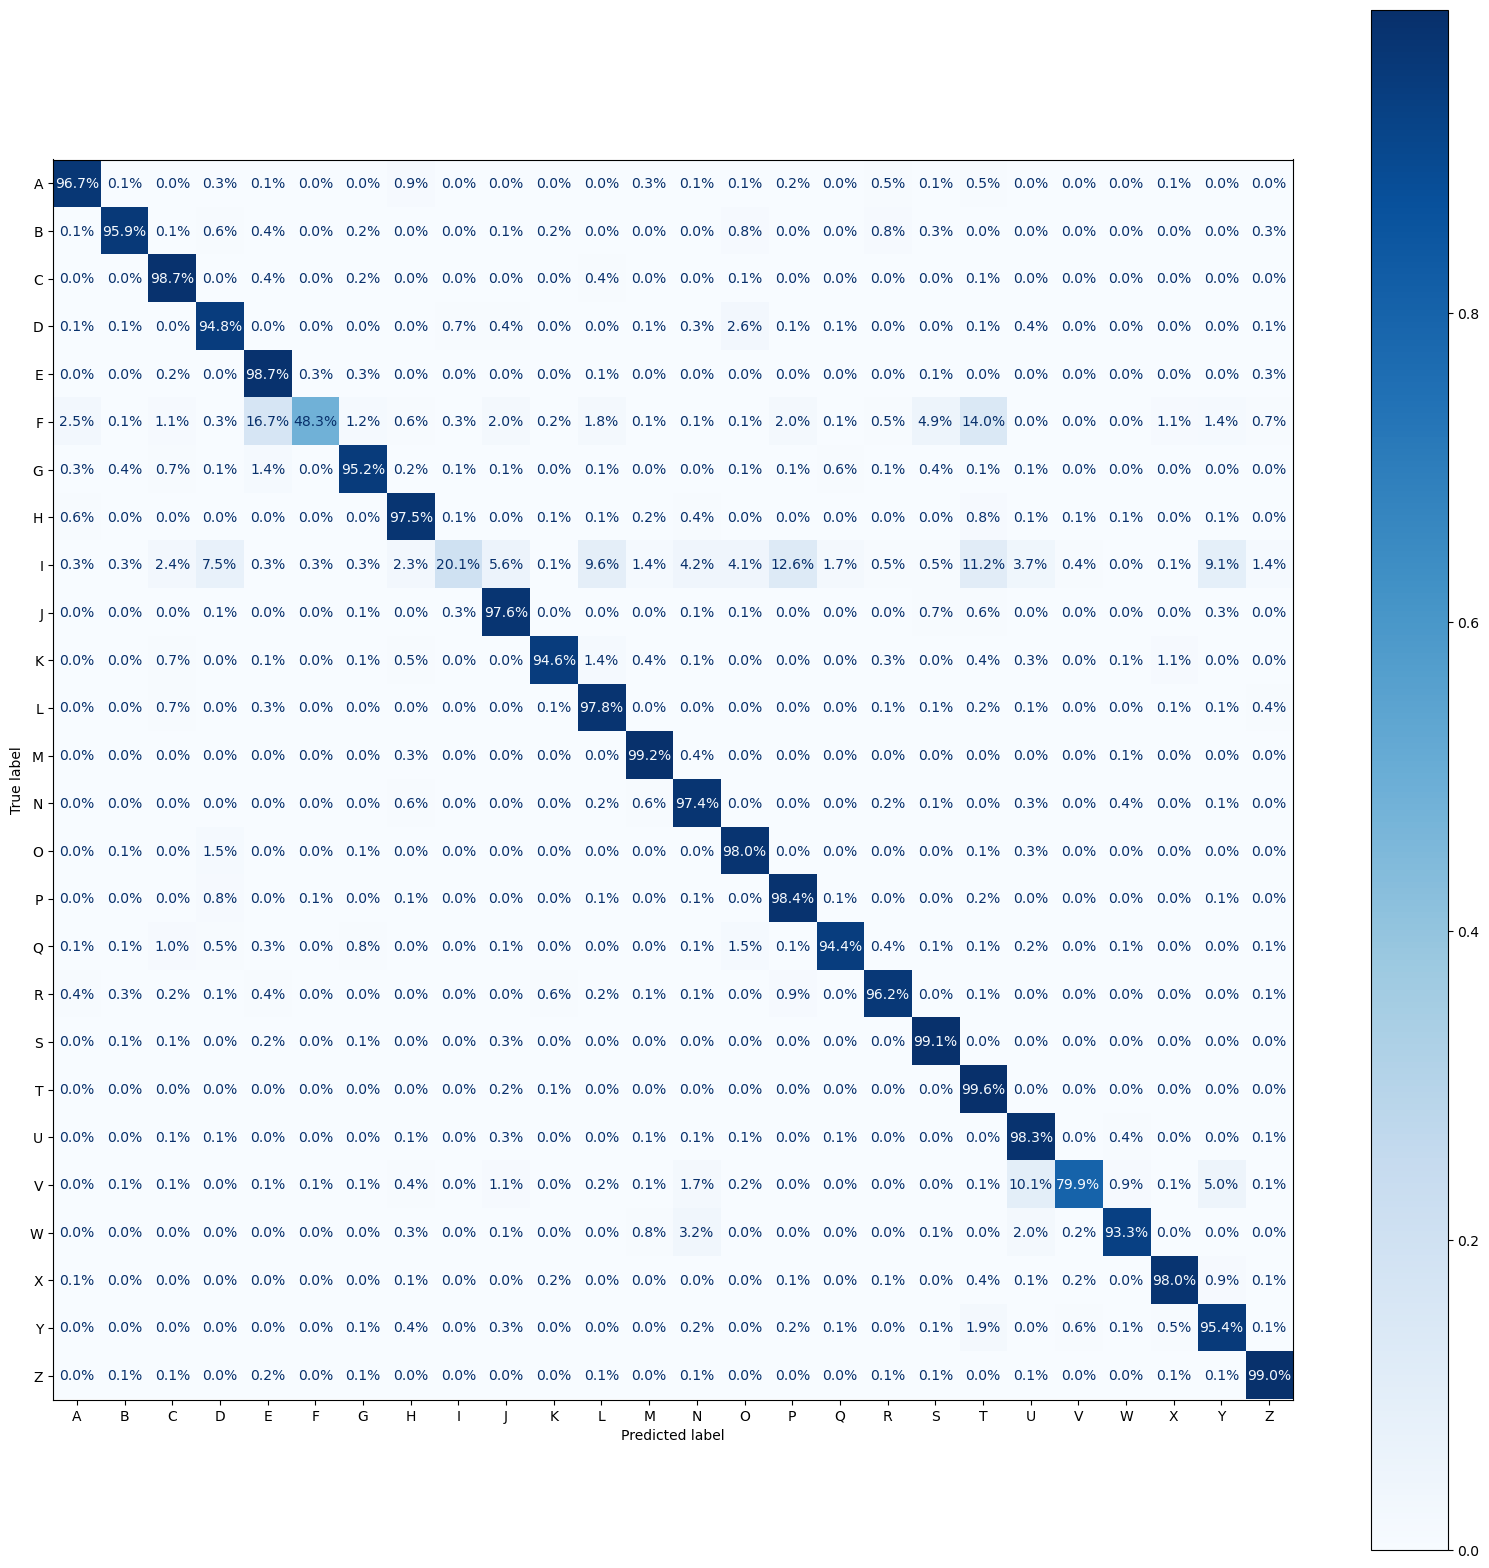

In [141]:
from sklearn import metrics

class estimator: #This is used to create a confusion matrix by passing our model as a estimator to sklearn
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred
mod = models.load_model("models/mod64w.h5")
classifier = estimator(mod,ticks)
fig, ax = plt.subplots( figsize=(20,20)) 
metrics.ConfusionMatrixDisplay.from_estimator(classifier, X = X_test, y = Y_test,ax=ax,normalize = 'true',display_labels = ticks,cmap = 'Blues',values_format = '.1%',colorbar= False)